# *Age Detection CNN*

Dataset: https://www.kaggle.com/datasets/jangedoo/utkface-new

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomRotation, RandomZoom, InputLayer,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')


## Allow GPU Utilization

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Constants

In [4]:
BATCH_SIZE = 32
EPOCHS = 250
IMG_HEIGHT = 200
IMG_WIDTH = 200
CHANNELS = 3
DATA_DIR = '../data'
CHECKPOINTS_DIR = "../training_checkpoints"
SAVED_MODEL_DIR = "../model"
MODEL_NAME = "age_guessing_model.keras"

## Data Preparation

In [5]:
def load_data():
    images = []
    labels = []
    
    for file_name in os.listdir(DATA_DIR):
        if file_name.endswith('.jpg'):
            age = int(file_name.split('_')[0])
            image = Image.open(os.path.join(DATA_DIR, file_name)).resize((IMG_WIDTH, IMG_HEIGHT))
            image = (np.array(image)) / 255
            images.append(np.array(image))
            labels.append(age)
    
    return np.array(images), np.array(labels)

In [6]:
images, labels = load_data()

## Split the data into training and testing

In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

## Visualize the data

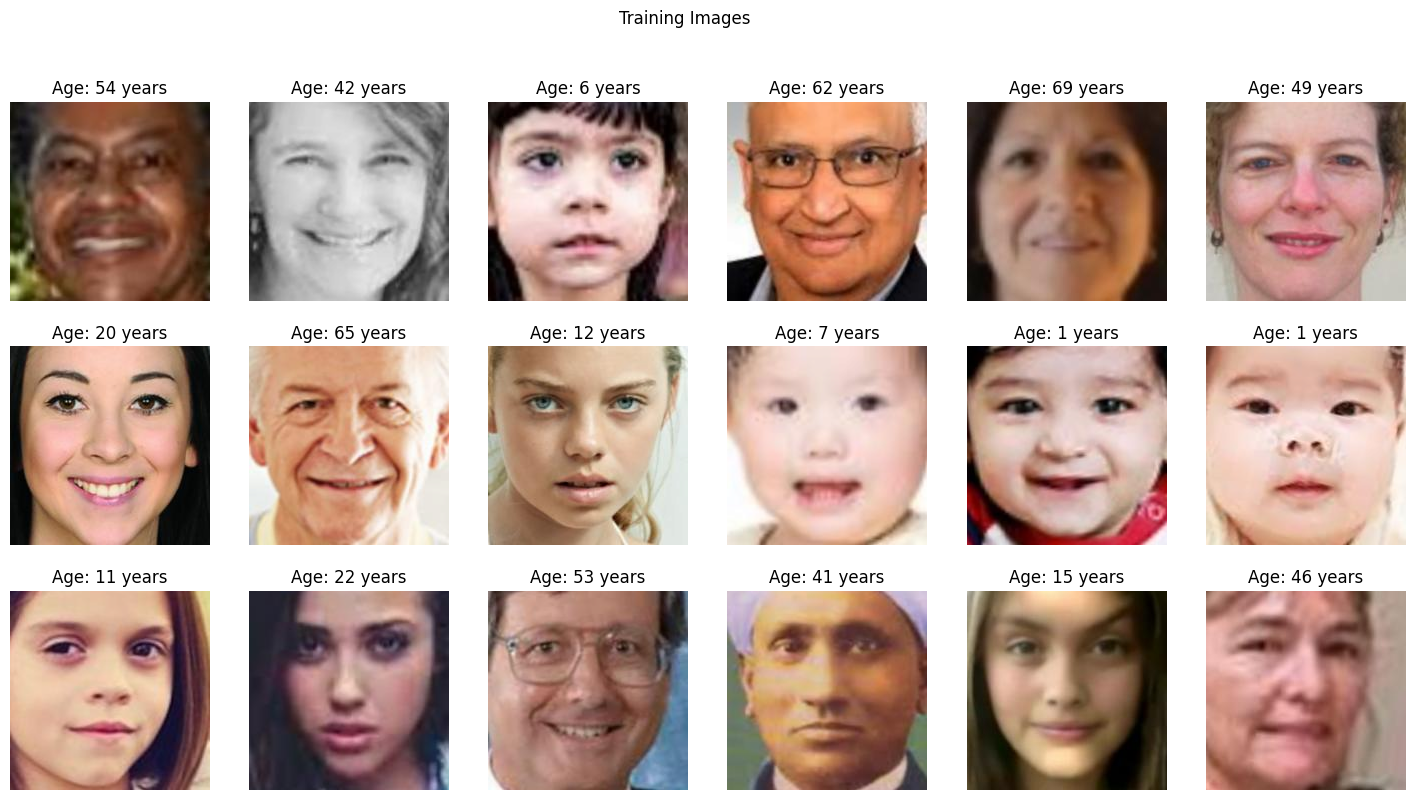

In [8]:
plt.figure(figsize=(18, 9))
plt.suptitle("Training Images")
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(train_images[i])
    plt.title(f"Age: {train_labels[i]} years")
    plt.axis('off')
plt.show()    

In [9]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

model = Sequential([
    InputLayer(input_shape=input_shape),

    # Data Augmentation Layers
    RandomRotation(0.2),
    RandomZoom(0.2),
    
    Conv2D(32, 3, activation='relu'),
    
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, 3, activation='relu'),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(265, 3, activation='relu'),
    Conv2D(265, 3, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1),
])

model.build(input_shape=input_shape)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1

In [11]:
# Include the epoch in the file name (uses `str.format`)

checkpoint_path = CHECKPOINTS_DIR+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Calculate the number of batches per epoch
n_batches = len(train_images) / BATCH_SIZE
# round up the number of batches to the nearest whole integer
n_batches = math.ceil(n_batches)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

In [12]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mae"]
)

In [13]:
model.save_weights(checkpoint_path.format(epoch=0))

In [14]:
history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(test_images, test_labels), callbacks=[cp_callback])

Epoch 1/250
245/245 [==============================] - 53s 181ms/step - loss: 745.2139 - mae: 21.8215 - val_loss: 606.0906 - val_mae: 19.9073
Epoch 2/250
245/245 [==============================] - 42s 171ms/step - loss: 624.1649 - mae: 20.4747 - val_loss: 614.8832 - val_mae: 19.3767
Epoch 3/250
245/245 [==============================] - 42s 170ms/step - loss: 581.1444 - mae: 19.2419 - val_loss: 494.7316 - val_mae: 17.2749
Epoch 4/250
245/245 [==============================] - 42s 172ms/step - loss: 492.3665 - mae: 17.1441 - val_loss: 535.8105 - val_mae: 15.8826
Epoch 5/250
244/245 [============================>.] - ETA: 0s - loss: 433.7724 - mae: 15.8926
Epoch 5: saving model to ../training_checkpoints\cp-0005.ckpt
245/245 [==============================] - 42s 172ms/step - loss: 434.1693 - mae: 15.9000 - val_loss: 373.2854 - val_mae: 13.6714
Epoch 6/250
245/245 [==============================] - 40s 163ms/step - loss: 382.5275 - mae: 14.5794 - val_loss: 278.4700 - val_mae: 11.8181
Epo

In [15]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

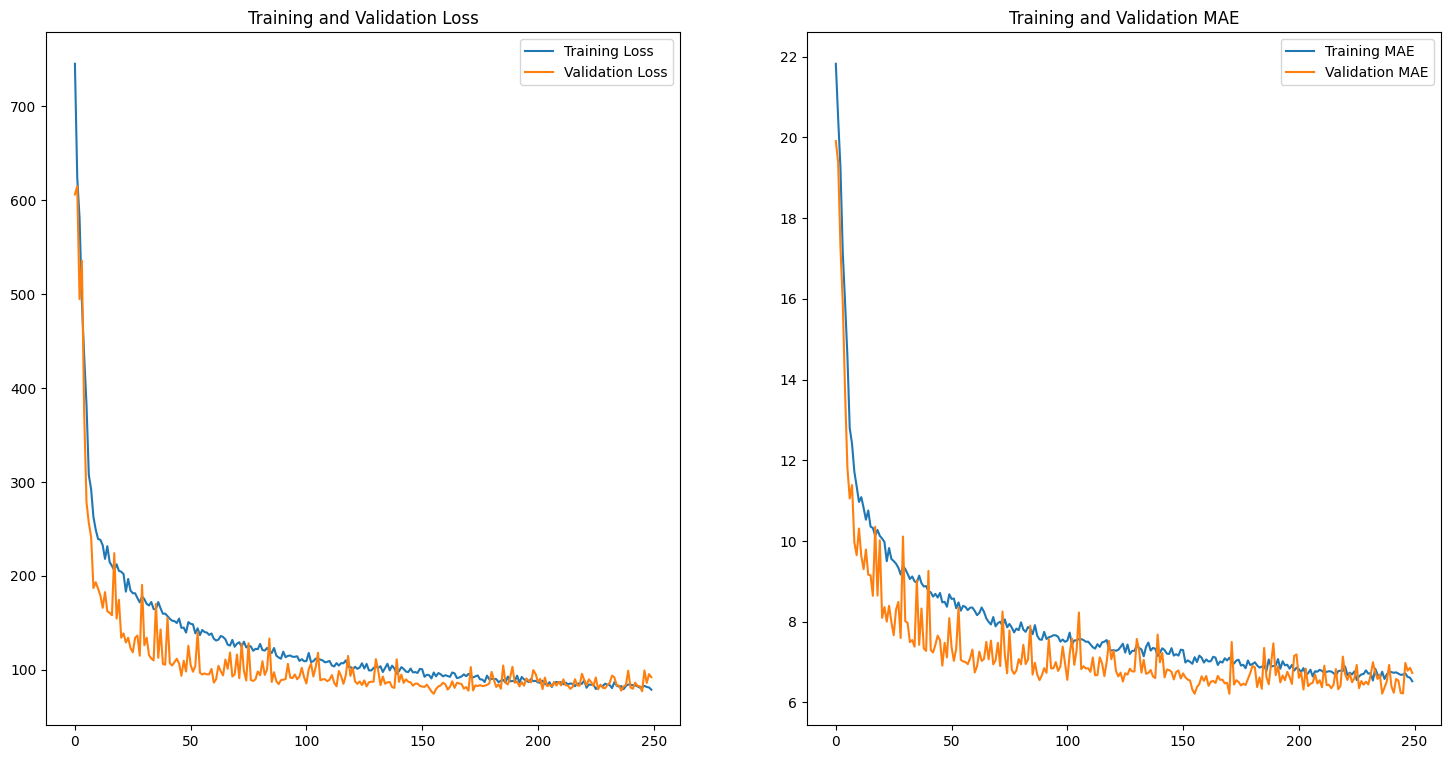

In [17]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')
plt.show()


1/1 [==============================] - 0s 11ms/step


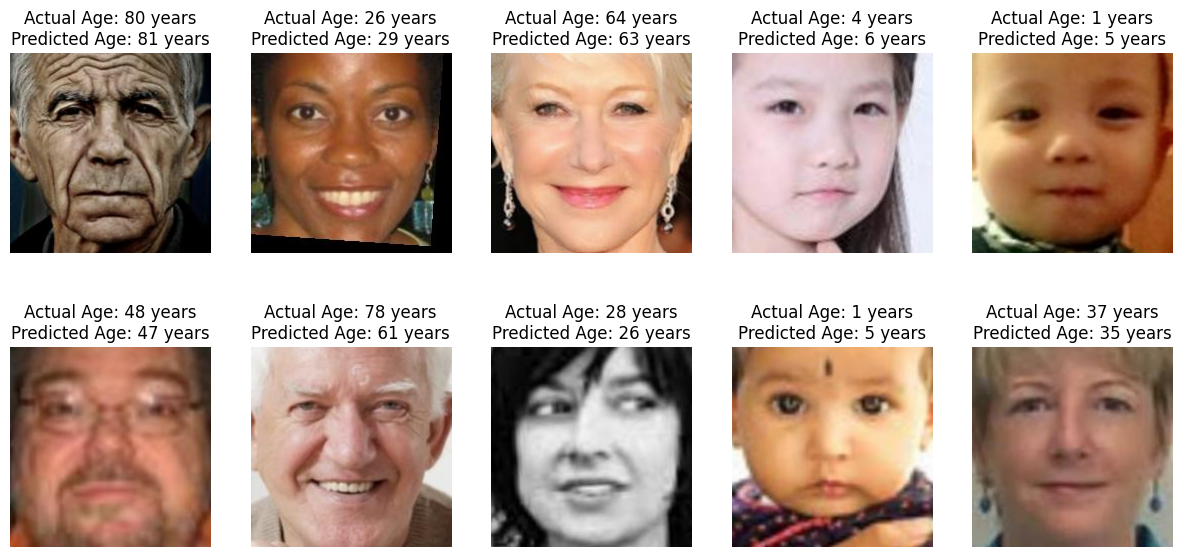

In [59]:
plt.figure(figsize=(15, 7))
for i in range(10):
    random_index = np.random.randint(0, len(test_images))
    test_image = test_images[random_index]
    test_label = test_labels[random_index]
    test_image = np.expand_dims(test_image, axis=0)
    predicted_label = model.predict(test_image)[0][0]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_image[0])
    plt.title(f"Actual Age: {test_label} years\nPredicted Age: {int(predicted_label)} years")
    plt.axis('off')
    
plt.show()

In [20]:
model.save(SAVED_MODEL_DIR+"/"+MODEL_NAME)